In [ ]:
%matplotlib inline

In [12]:
import os.path as op
import matplotlib.pyplot as plt
import mne
import numpy as np
from mne.datasets import sample
from mne import setup_volume_source_space, setup_source_space
from mne import make_forward_solution
from mne.minimum_norm import make_inverse_operator, apply_inverse
from mne.beamformer import make_lcmv, apply_lcmv
%gui qt

from nilearn.plotting import plot_stat_map
from nilearn.image import index_img
import numpy as np
from mayavi import mlab

# Set dir
data_path = sample.data_path()
subject = 'sample'
data_dir = op.join(data_path, 'MEG', subject)
subjects_dir = op.join(data_path, 'subjects')
bem_dir = op.join(subjects_dir, subject, 'bem')

# Set file names
fname_aseg = op.join(subjects_dir, subject, 'mri', 'aseg.mgz')
fname_model = op.join(bem_dir, '%s-5120-bem.fif' % subject)
fname_bem = op.join(bem_dir, '%s-5120-bem-sol.fif' % subject)
raw_fname = data_path + '/MEG/sample/sample_audvis_raw.fif'
event_fname = data_path + '/MEG/sample/sample_audvis_raw-eve.fif'
fname_evoked = data_dir + '/sample_audvis-ave.fif'
fname_trans = data_dir + '/sample_audvis_raw-trans.fif'
fname_fwd = data_dir + '/sample_audvis-meg-oct-6-mixed-fwd.fif'
fname_cov = data_dir + '/sample_audvis-shrunk-cov.fif'

In [13]:
event_id, tmin, tmax = 1, -0.2, 0.5
# Setup for reading the raw data
raw = mne.io.read_raw_fif(raw_fname, preload=True)
raw.info['bads'] = ['MEG 2443', 'EEG 053']  # 2 bads channels
events = mne.read_events(event_fname)
# Set up pick list: EEG + MEG - bad channels (modify to your needs)
left_temporal_channels = mne.read_selection('Left-temporal')
picks = mne.pick_types(raw.info, meg=True, eeg=False, stim=True, eog=True,
                       exclude='bads', selection=left_temporal_channels)
# Pick the channels of interest
raw.pick_channels([raw.ch_names[pick] for pick in picks])
# Re-normalize our empty-room projectors, so they are fine after subselection
raw.info.normalize_proj()
# Read epochs
proj = False  # already applied
epochs = mne.Epochs(raw, events, event_id, tmin, tmax,
                    baseline=(None, 0), preload=True, proj=proj,
                    reject=dict(grad=4000e-13, mag=4e-12, eog=150e-6))
evoked = epochs.average()
noise_cov = mne.compute_covariance(epochs, tmin=tmin, tmax=0, method='shrunk')
data_cov = mne.compute_covariance(epochs, tmin=0.04, tmax=0.15,
                                  method='shrunk')

Opening raw data file C:\Users\PP255359\mne_data\MNE-sample-data\MEG\sample\sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Current compensation grade : 0
Reading 0 ... 166799  =      0.000 ...   277.714 secs...
72 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
Created an SSP operator (subspace dimension = 3)
Loading data for 72 events and 421 original time points ...
    Rejecting  epoch based on EOG : [u'EOG 061']
    Rejecting  epoch based on EOG : [u'EOG 061']
    Rejecting  epoch based on EOG : [u'EOG 061']
    Rejecting  epoch based on EOG : [u'EOG 061']
    Rejecting  epoch based on EOG : [u'EOG 061']
    Rejecting  epoch based on EOG : [u'EOG 061']
    Rejecting  epoch based on EOG : [u'EOG 061']
    Rejecting  epoch based on EOG : [u'EOG 061']
    Rejecting  epoch 

In [14]:
labels_vol = ['Left-Hippocampus']
sphere=(0,0,0,120)
src = setup_volume_source_space(subject, mri=fname_aseg, pos=2.0, sphere=sphere,
                                        volume_label=labels_vol, subjects_dir=subjects_dir, 
                                        verbose=True)
# Compute the fwd matrix
fwd = make_forward_solution(evoked.info, fname_trans, src, fname_bem,
                            mindist=5.0,  # ignore sources<=5mm from innerskull
                            meg=True, eeg=False, n_jobs=1)

leadfield = fwd['sol']['data']
print("Leadfield size : %d sensors x %d dipoles" % leadfield.shape)

src_fwd = fwd['src']
n = sum(src_fwd[i]['nuse'] for i in range(len(src_fwd)))
print('the fwd src space contains %d spaces and %d points' % (len(src_fwd), n))



filters = make_lcmv(evoked.info, fwd, data_cov, reg=0.5,
                    noise_cov=noise_cov, pick_ori='max-power',
                    weight_norm='nai')
stc = apply_lcmv(evoked, filters, max_ori_out='signed')


Sphere                : origin at (0.0 0.0 0.0) mm
              radius  : 120.0 mm
grid                  : 2.0 mm
mindist               : 5.0 mm
MRI volume            : C:\Users\PP255359\mne_data\MNE-sample-data\subjects\sample\mri\aseg.mgz

Setting up the sphere...
Surface CM = (   0.0    0.0    0.0) mm
Surface fits inside a sphere with radius  120.0 mm
Surface extent:
    x = -120.0 ...  120.0 mm
    y = -120.0 ...  120.0 mm
    z = -120.0 ...  120.0 mm
Grid extent:
    x = -122.0 ...  122.0 mm
    y = -122.0 ...  122.0 mm
    z = -122.0 ...  122.0 mm
1860867 sources before omitting any.
904009 sources after omitting infeasible sources.
796903 sources remaining after excluding the sources outside the surface and less than    5.0 mm inside.
Selecting voxels from Left-Hippocampus
450 sources remaining after excluding sources too far from VOI voxels
Adjusting the neighborhood info...
Reading C:\Users\PP255359\mne_data\MNE-sample-data\subjects\sample\mri\aseg.mgz...
Source space : MRI v

In [15]:
src = fwd['src']

# Export result as a 4D nifti object
img = stc.as_volume(src,
                    mri_resolution=False)  # set True for full MRI resolution

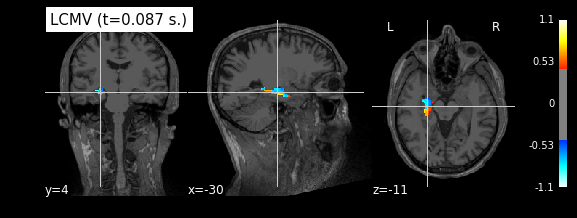

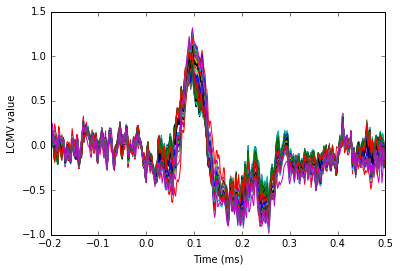

In [16]:

# Save it as a nifti file
# nib.save(img, 'mne_%s_inverse.nii.gz' % method)

t1_fname = data_path + '/subjects/sample/mri/T1.mgz'
idx = stc.time_as_index(0.088)
plot_stat_map(index_img(img, idx), t1_fname, threshold=0.45,
              title='LCMV (t=%.3f s.)' % stc.times[idx])

# plot source time courses with the maximum peak amplitudes at 88 ms
plt.figure()
plt.plot(stc.times, stc.data[np.argsort(np.max(stc.data[:, idx],
                                               axis=1))[-40:]].T)
plt.xlabel('Time (ms)')
plt.ylabel('LCMV value')
plt.show()


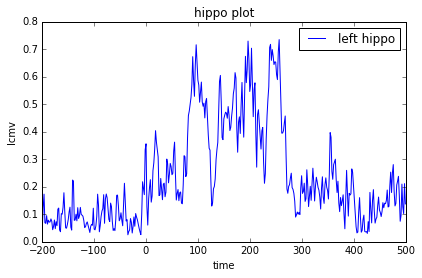

In [17]:
src = fwd['src']
stc.data[:, :] = np.abs(stc.data)
fig,axes=plt.subplots(1)
axes.plot(1e3*stc.times, np.mean(stc.data,axis=0), label='left hippo')

axes.set(xlabel='time', ylabel='lcmv', title='hippo plot')
axes.legend()
mne.viz.tight_layout()
plt.show()